<a href="https://colab.research.google.com/github/nixonline/Promo_Analysis/blob/main/Promo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Info

## Task

![picture](https://play-lh.googleusercontent.com/AvEO4gWZRHqrkEUV-6JUyAXaj9_MyLGURE7eX-4H5wvB0_7P5LfYRyfNkHCxXgrXvRc)

Hey You App is an order-ahead application where customer can order from. The goal is to perform an exploratory data analysis on the given dataset to understand customer behavior, profile and impact of promo.

## Dataset

This is a dummy data reflecting real world transactions.


### Features and Description

*   Trans_date - Transaction Date
*   Trans_hour - Transaction Hour
*   Customers - Number of unique customers active/ordering
*   Vendors - Number of unique vendors active/ordering
*   Orders - Number of unique orders through the app
*   Amount - Total processed order amount in Australian dollars
*   Promo_count - Number of orders with promos
*   Android - Number of unique customers who used Android Device
*   GCF - Number of unique customers who used Google Food Ordering
*   Macintosh - Number of unique customers who used Mac
*   Tablet - Number of unique customers who used iPad/iPod
*   Windows - Number of unique customers who used Windows Device
*   X11 - Number of unique customers who used Linux / CrOS Device
*   iPhone - Number of unique customers who used iPhone
*   Blacklisted - Number of unique customers blacklisted (note of course at the time of ordering they weren’t blacklisted yet, but eventually, they were)
*   Not Blacklisted - Number of unique customers who are not blacklisted



### Notes

*   Around the first week of May 2021 and thereafter, we implemented an AI system that
has helped grow active customers and customer ordering.
*   Covid restrictions and reopenings in Australia apply and may/may not affect order-ahead behaviours.

# Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import plotly.express as px

import seaborn as sns
sns.set_theme(style="white")

from scipy import interpolate

# Preprocessing

## Load File

In [34]:
FILE_URL = "/content/drive/MyDrive/Colab Notebooks/Hey You DS Exam/data/promo_order_data.csv"
df = pd.read_csv(FILE_URL)

# Per instructions, the column 'promo_amount' is to be ignored and therefore dropped from the dataset
df.drop(columns=['promo_amount'], inplace=True)
df.head()

,trans_date,trans_hour,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,Blacklisted,Not Blacklisted
0,2021-01-01,6,52.0,36.0,52.0,350.70,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,52.0
1,2021-01-01,7,248.0,104.0,250.0,2372.48,2.0,16.0,4.0,0.0,0.0,0.0,2.0,76.0,0.0,248.0
2,2021-01-01,8,584.0,168.0,594.0,6651.32,4.0,22.0,6.0,0.0,0.0,2.0,2.0,184.0,0.0,584.0
3,2021-01-01,9,786.0,196.0,812.0,9350.64,10.0,38.0,26.0,0.0,0.0,0.0,2.0,232.0,0.0,786.0
4,2021-01-01,10,894.0,200.0,924.0,10956.32,8.0,46.0,22.0,4.0,0.0,0.0,2.0,230.0,0.0,894.0


## Dataset size, nulls, and types



In [35]:
def df_info(df):
    print("Dataset size \n-----------------------")
    print("Rows:", df.shape[0], "\nFeatures:", df.shape[1])

    print("\nNull values \n-----------------------")

    if(df.isnull().sum().sum() == 0):
        print("No null values found!")
    else:
        print(df.isnull().sum())

    print("\nData types \n-----------------------")
    print(df.dtypes)

In [36]:
df_info(df)

Dataset size 
-----------------------
Rows: 2485 
Features: 16

Null values 
-----------------------
trans_date          0
trans_hour          0
customers           0
vendors             0
orders              0
amount              0
promo_count         0
Android            30
GCF                30
Macintosh          30
Tablet             30
Windows            30
X11                30
iPhone             30
Blacklisted         0
Not Blacklisted     0
dtype: int64

Data types 
-----------------------
trans_date          object
trans_hour           int64
customers          float64
vendors            float64
orders             float64
amount             float64
promo_count        float64
Android            float64
GCF                float64
Macintosh          float64
Tablet             float64
Windows            float64
X11                float64
iPhone             float64
Blacklisted        float64
Not Blacklisted    float64
dtype: object


### Null Values

In [37]:
df_nulls = df[df.isnull().any(axis=1)]
df_nulls.head()

,trans_date,trans_hour,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,Blacklisted,Not Blacklisted
128,2021-01-09,5,2.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
191,2021-01-12,23,2.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
242,2021-01-16,2,2.0,2.0,2.0,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
407,2021-01-26,5,2.0,2.0,2.0,8.4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
439,2021-01-27,21,2.0,2.0,2.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0


*    There are **30 rows** with null values on the same set of features.
*    On the first glance, given the number of rows, it makes sense to drop those with missing values.
*    However, given the time context of the dataset, a gap could mean different things for a business.
*    Therefore, interpolation will be used to fill the null values.


In [38]:
# Simple interpolate
# - No consecutive nulls detected and therefore linear method will suffice
# - No null placed on both ends of dataset and therefore direction is forward
# - Round to whole number
cols_with_null = df_nulls.isnull().sum().loc[lambda x : x > 0].index.tolist()
df[cols_with_null] = df[cols_with_null].interpolate(method ='linear', limit_direction ='forward').round(0)

# Double check if null values remain
print('Null values  : ', df.isnull().sum().sum())

Null values  :  0


In [39]:
df.loc[df_nulls.index.tolist()].head()

,trans_date,trans_hour,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,Blacklisted,Not Blacklisted
128,2021-01-09,5,2.0,2.0,2.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,1.0,68.0,0.0,2.0
191,2021-01-12,23,2.0,2.0,2.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0
242,2021-01-16,2,2.0,2.0,2.0,200.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
407,2021-01-26,5,2.0,2.0,2.0,8.4,2.0,6.0,3.0,0.0,0.0,0.0,0.0,54.0,0.0,2.0
439,2021-01-27,21,2.0,2.0,2.0,112.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0


### Data Types

In [40]:
# Date to datetime object
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%Y-%m-%d')

# Floats to int
int_cols = df.columns.tolist()[1:]
df[int_cols] = df[int_cols].astype(int)

# Feature Engineering

## Buckets

### Time of Day

In [41]:
df['time_bucket'] = pd.cut(df['trans_hour'], bins=[0, 6, 12, 18, 24], include_lowest=True, labels=['night', 'morning', 'afternooon', 'evening'])

### Device

Android - Number of unique customers who used Android Device
GCF - Number of unique customers who used Google Food Ordering
Macintosh - Number of unique customers who used Mac
Tablet - Number of unique customers who used iPad/iPod
Windows - Number of unique customers who used Windows Device
X11 - Number of unique customers who used Linux / CrOS Device
iPhone - Number of unique customers who used iPhone

In [42]:
df['mobile'] = df['Android'] + df['iPhone'] + df['Tablet']
df['non-mobile'] = df['Windows'] + df['X11'] + df['Macintosh']

## Mean Amount per Order

In [43]:
df['mean_amt_per_order'] = df['amount']/df['orders']

## AI Implementation in App

In [44]:
df['ai_implemented'] = df.apply(lambda x: 1 if x['trans_date'] >= pd.to_datetime('2021-05-01') else 0, axis=1)

In [45]:
print("Samples before and after AI implementation \n------------------------------------------")
df['ai_implemented'].value_counts()

Samples before and after AI implementation 
------------------------------------------


0    1980
1     505
Name: ai_implemented, dtype: int64

## COVID Impact


The impact of COVID to businesses will be considered on this research. The number of cases per day will be used as an additional feature for the orders dataset.

Source: https://covid19.who.int/data

In [46]:
FILE_URL2 = "/content/drive/MyDrive/Colab Notebooks/Hey You DS Exam/data/WHO-COVID-19-global-data.csv"
au_covid_df = pd.read_csv(FILE_URL2)

# Date column dtype
au_covid_df['Date_reported'] = pd.to_datetime(au_covid_df['Date_reported'], format='%Y-%m-%d')
# Filter AU country only
au_covid_df = au_covid_df[au_covid_df['Country']=='Australia']
au_covid_df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
13849,2020-01-03,AU,Australia,WPRO,0,0,0,0
13850,2020-01-04,AU,Australia,WPRO,0,0,0,0
13851,2020-01-05,AU,Australia,WPRO,0,0,0,0
13852,2020-01-06,AU,Australia,WPRO,0,0,0,0
13853,2020-01-07,AU,Australia,WPRO,0,0,0,0


In [47]:
au_covid_agg_df = au_covid_df.groupby('Date_reported')['New_cases'].sum().to_frame().reset_index()
au_covid_agg_df.head()

,Date_reported,New_cases
0,2020-01-03,0
1,2020-01-04,0
2,2020-01-05,0
3,2020-01-06,0
4,2020-01-07,0


In [48]:
df = df.merge(au_covid_agg_df, left_on='trans_date', right_on='Date_reported', how='left').drop(columns = ['Date_reported']).rename(columns={'New_cases': 'covid_confirmed_cases'})
df.head()

,trans_date,trans_hour,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,...,X11,iPhone,Blacklisted,Not Blacklisted,time_bucket,mobile,non-mobile,mean_amt_per_order,ai_implemented,covid_confirmed_cases
0,2021-01-01,6,51,36,51,350,0,2,0,0,...,0,22,0,51,night,24,0,6.862745,0,46
1,2021-01-01,7,248,104,250,2372,2,16,4,0,...,2,76,0,248,morning,92,2,9.488000,0,46
2,2021-01-01,8,584,168,594,6651,4,22,6,0,...,2,184,0,584,morning,206,4,11.196970,0,46
3,2021-01-01,9,785,196,812,9350,10,38,26,0,...,2,232,0,785,morning,270,2,11.514778,0,46
4,2021-01-01,10,894,200,924,10956,8,46,22,4,...,2,230,0,894,morning,276,6,11.857143,0,46


## Expanding Time Feature

In [49]:
print('Date Scope : ', df['trans_date'].min(), 'to', df['trans_date'].max())

Date Scope :  2021-01-01 00:00:00 to 2021-05-31 00:00:00


In [86]:
def expand_features(df):
  df['month'] = df['trans_date'].dt.month
  df['day_of_month'] = df['trans_date'].dt.day
  df['day_of_week'] = df['trans_date'].dt.dayofweek
  df['day_of_week_txt'] = df['trans_date'].dt.day_name()
  df['week_of_year'] = df['trans_date'].dt.weekofyear
  df['week_of_month'] = df['trans_date'].apply(lambda d : str(d.day//8+1))

  return df

In [87]:
df = expand_features(df)
df.head()

<ipython-input-86-a2d096f1a1ea>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['trans_date'].dt.weekofyear


,trans_date,trans_hour,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,...,non-mobile,mean_amt_per_order,ai_implemented,covid_confirmed_cases,month,day_of_month,day_of_week,week_of_year,week_of_month,day_of_week_txt
0,2021-01-01,6,51,36,51,350,0,2,0,0,...,0,6.862745,0,46,1,1,4,53,1,Friday
1,2021-01-01,7,248,104,250,2372,2,16,4,0,...,2,9.488000,0,46,1,1,4,53,1,Friday
2,2021-01-01,8,584,168,594,6651,4,22,6,0,...,4,11.196970,0,46,1,1,4,53,1,Friday
3,2021-01-01,9,785,196,812,9350,10,38,26,0,...,2,11.514778,0,46,1,1,4,53,1,Friday
4,2021-01-01,10,894,200,924,10956,8,46,22,4,...,6,11.857143,0,46,1,1,4,53,1,Friday


The dataset contains 5 months of data from the same year. Month and week of month will be included for the analysis.

# Exploratory Data Analysis

## Basic Statistics

In [52]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trans_hour,2485.0,12.748893,4.803603,0.0,9.000000,13.000000,17.000000,23.0
customers,2485.0,1368.453924,2004.239301,2.0,28.000000,474.000000,1892.000000,9910.0
vendors,2485.0,388.423742,408.809404,2.0,20.000000,254.000000,624.000000,1482.0
orders,2485.0,1391.726358,2035.513881,2.0,28.000000,482.000000,1924.000000,10046.0
amount,2485.0,10501.354930,13429.963860,0.0,625.000000,4485.000000,14793.000000,63756.0
promo_count,2485.0,28.857545,52.011207,0.0,0.000000,4.000000,32.000000,442.0
Android,2485.0,76.088129,107.749620,0.0,2.000000,26.000000,106.000000,556.0
GCF,2485.0,24.293360,27.419397,0.0,2.000000,12.000000,40.000000,138.0
Macintosh,2485.0,1.476861,2.545236,0.0,0.000000,0.000000,2.000000,16.0
Tablet,2485.0,0.793159,1.620332,0.0,0.000000,0.000000,2.000000,12.0


## Correlations

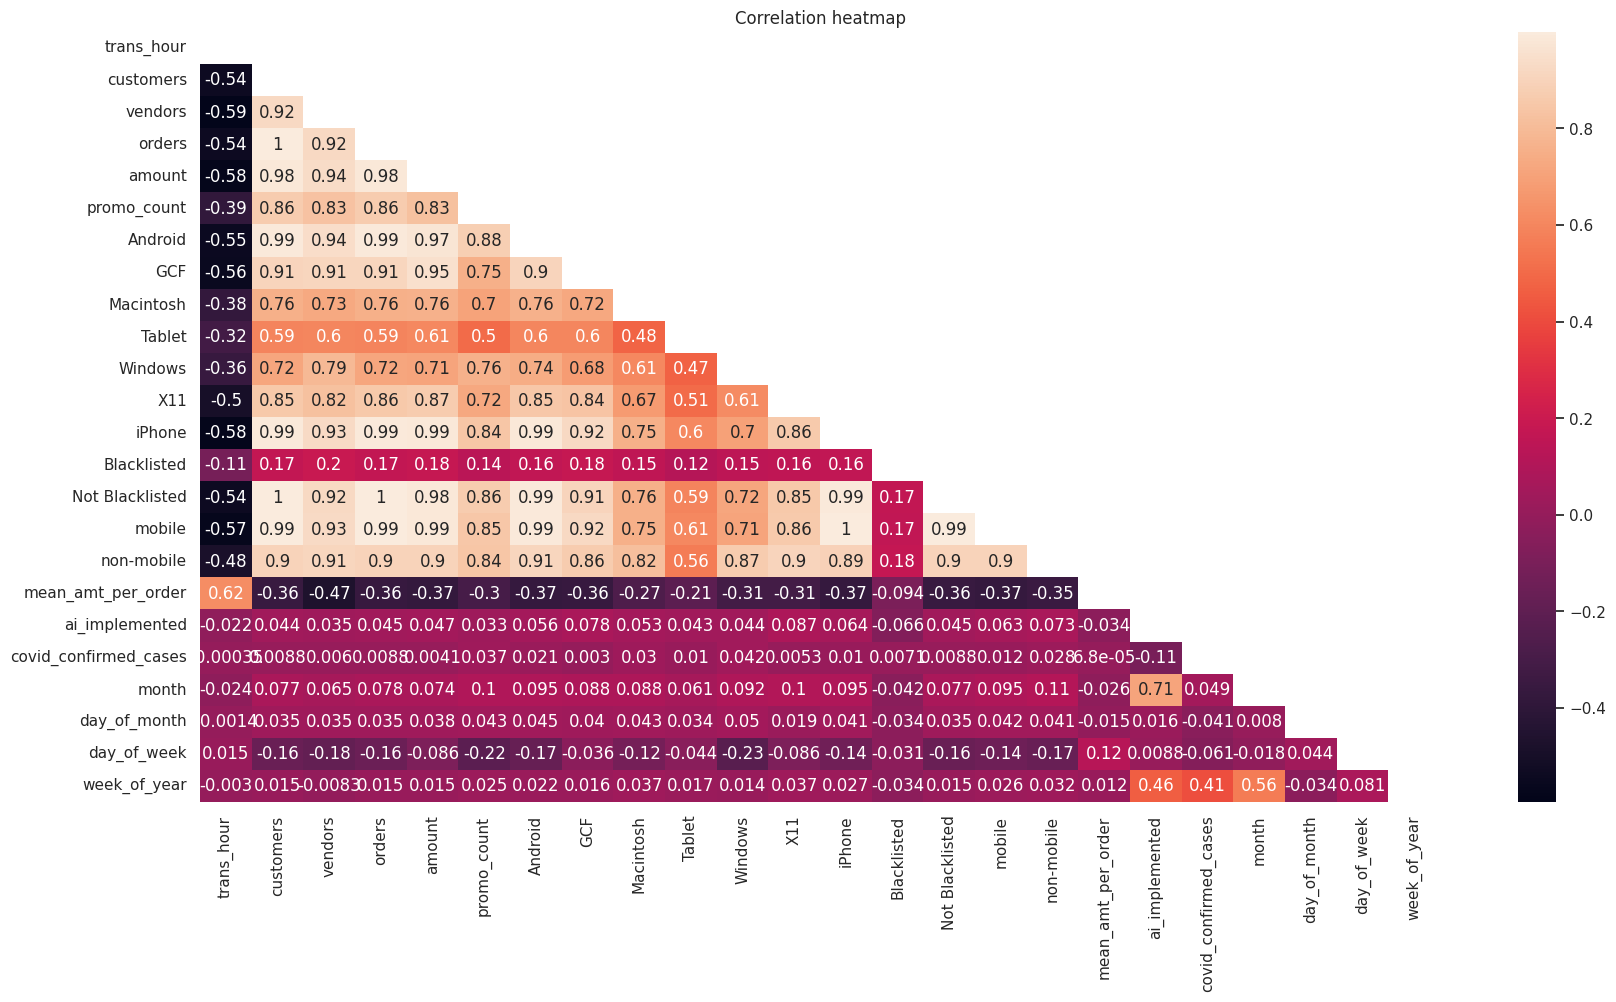

In [53]:
corr = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(corr, annot=True, mask=mask)

plt.title("Correlation heatmap")
plt.show()

A quick glance on the correlation heatmap shows that:

*   There are moderate to very high correlations between features.
*   Count of COVID cases has negligible correlation on the business metrics.



## Orders

In [78]:
df_wk = df[df.week_of_year <= 21].groupby('week_of_year').sum(numeric_only=True)

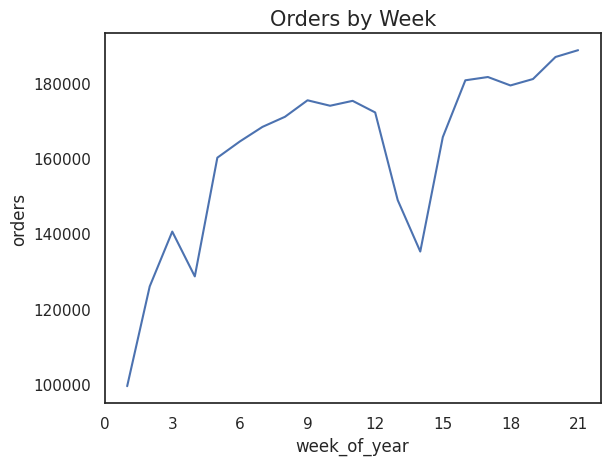

In [85]:
sns.lineplot(x=df_wk.index, y=df_wk.orders)
plt.xticks(np.arange(0, max(df_wk.index)+1, 3.0))
plt.title('Orders by Week', size=15)
plt.show()

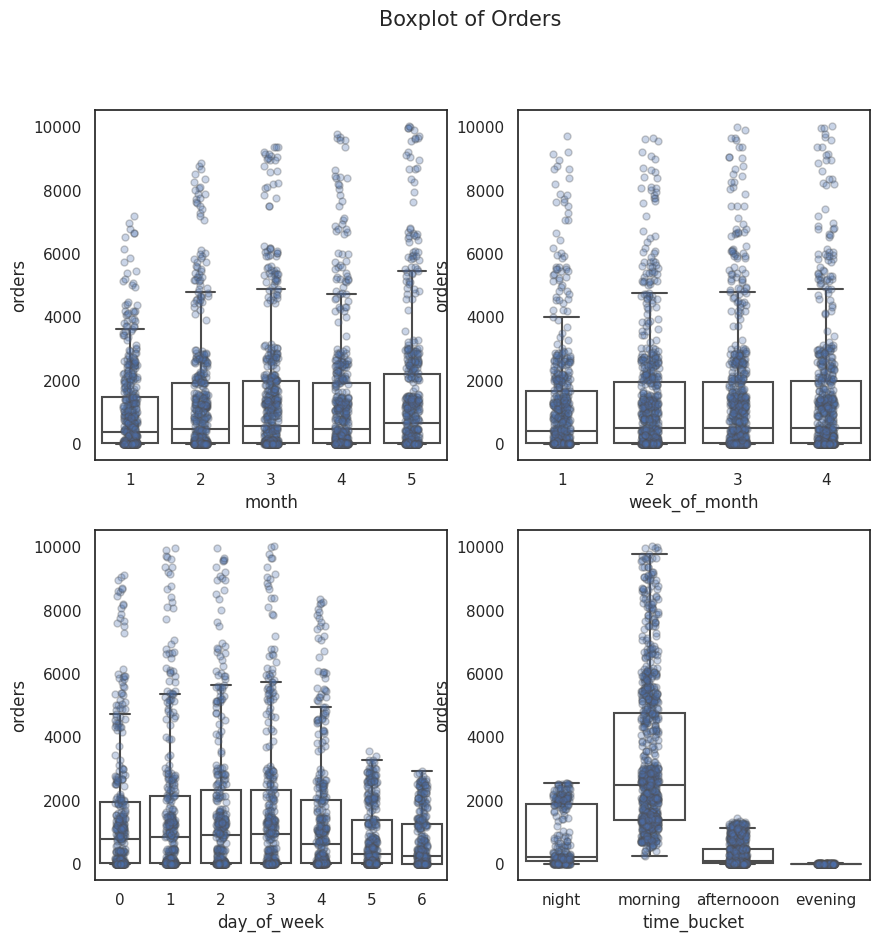

In [90]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x=df['month'], y=df['orders'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax1)
sns.stripplot(data=df, x='month', y='orders', jitter=True, alpha=.3, linewidth=1, ax=ax1)

sns.boxplot(x=df['week_of_month'], y=df['orders'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax2)
sns.stripplot(data=df, x='week_of_month', y='orders', jitter=True, alpha=.3, linewidth=1, ax=ax2)

sns.boxplot(x=df['day_of_week'], y=df['orders'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax3)
sns.stripplot(data=df, x='day_of_week', y='orders', jitter=True, alpha=.3, linewidth=1, ax=ax3)

sns.boxplot(x=df['time_bucket'], y=df['orders'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax4)
sns.stripplot(data=df, x='time_bucket', y='orders', jitter=True, alpha=.3, linewidth=1, ax=ax4)

plt.suptitle("Boxplot of Orders", size=15)
plt.show()


*   The business is doing well in terms of orders growth from January to May
*   Orders are lower during first week of the month.
*   There are less orders during the weekend and significantly lower number of outliers.
*   Majority of orders are placed during the morning while least during the evening.



## AI Implementation

**ANOVA** will be used to test if there is a significant difference between the mean values of orders prior and after the implementation of new AI system.

In [56]:
from scipy.stats import f_oneway

anova_result = f_oneway(df[df['trans_date'] >= pd.to_datetime('2021-05-01')].orders, df[df['trans_date'] < pd.to_datetime('2021-05-01')].orders)

print('======== ANOVA of Orders ========')
print('p-value  : ', anova_result[1])
if anova_result[1] < .05:
  print('\nP-value <.05 suggests that there is a statistically significant difference between orders on months when AI is implemented')
else:
  print('\nP-value >.05 suggests that there there is no statistically significant difference between orders on months when AI is implemented')

======== ANOVA of Orders ========
p-value  :  0.026501848763298565

P-value <.05 suggests that there is a statistically significant difference between orders on months when AI is implemented


## Promos

### Frequency

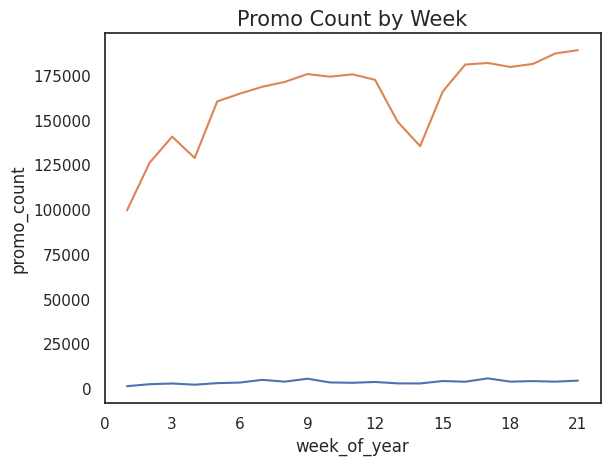

In [92]:
sns.lineplot(x=df_wk.index, y=df_wk.promo_count)
sns.lineplot(x=df_wk.index, y=df_wk.orders)
plt.xticks(np.arange(0, max(df_wk.index)+1, 3.0))
plt.title('Promo Count by Week', size=15)
plt.show()

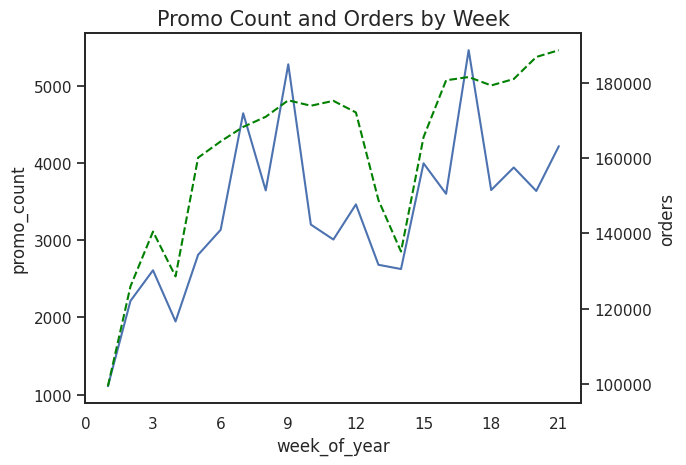

In [117]:
fig, ax1 = plt.subplots()
sns.lineplot(x=df_wk.index, y=df_wk.promo_count, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(x=df_wk.index, y=df_wk.orders, ax=ax2, color='green', linestyle='--')

plt.xticks(np.arange(0, max(df_wk.index)+1, 3.0))
plt.title('Promo Count and Orders by Week', size=15)

plt.show()

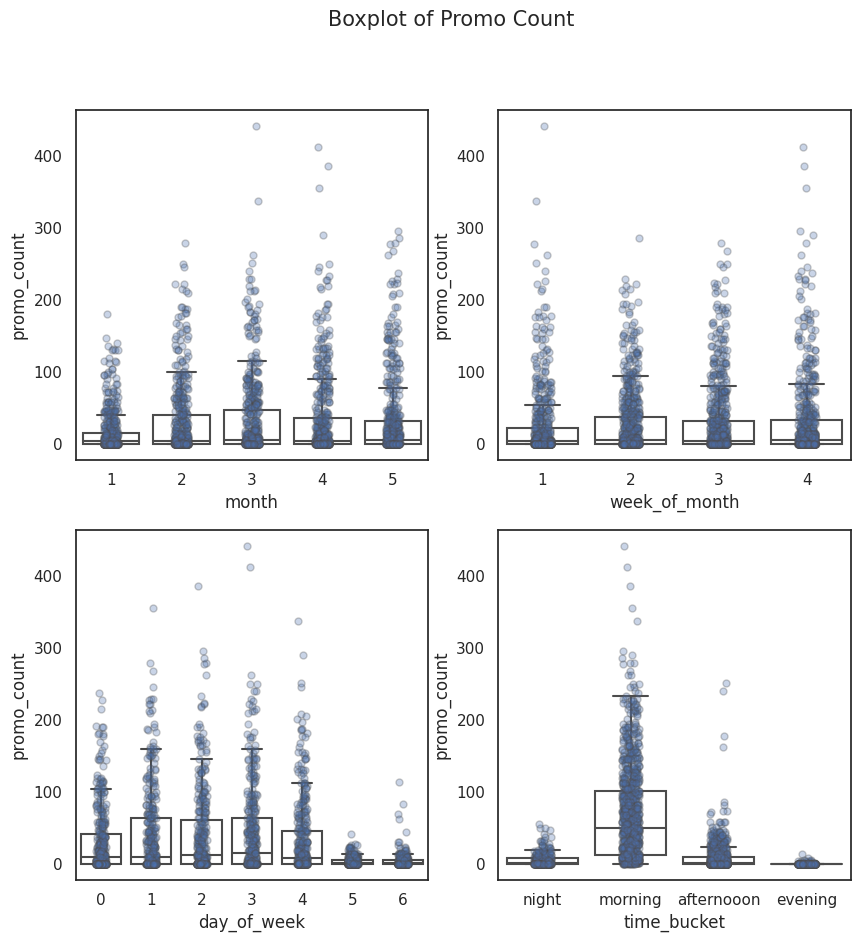

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x=df['month'], y=df['promo_count'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax1)
sns.stripplot(data=df, x='month', y='promo_count', jitter=True, alpha=.3, linewidth=1, ax=ax1)

sns.boxplot(x=df['week_of_month'], y=df['promo_count'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax2)
sns.stripplot(data=df, x='week_of_month', y='promo_count', jitter=True, alpha=.3, linewidth=1, ax=ax2)

sns.boxplot(x=df['day_of_week'], y=df['promo_count'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax3)
sns.stripplot(data=df, x='day_of_week', y='promo_count', jitter=True, alpha=.3, linewidth=1, ax=ax3)

sns.boxplot(x=df['time_bucket'], y=df['promo_count'], boxprops={'facecolor': 'none'}, orient='v', fliersize=0, ax=ax4)
sns.stripplot(data=df, x='time_bucket', y='promo_count', jitter=True, alpha=.3, linewidth=1, ax=ax4)

plt.suptitle("Boxplot of Promo Count", size=15)
plt.show()



*   Amount of promos given significanly increased from the January to February.
*   There are least amount of promos during start of the month.
*   There are significantly less promos given during weekends.
*   Promos are mostly given during the morning.


### Impact to Business Metrics

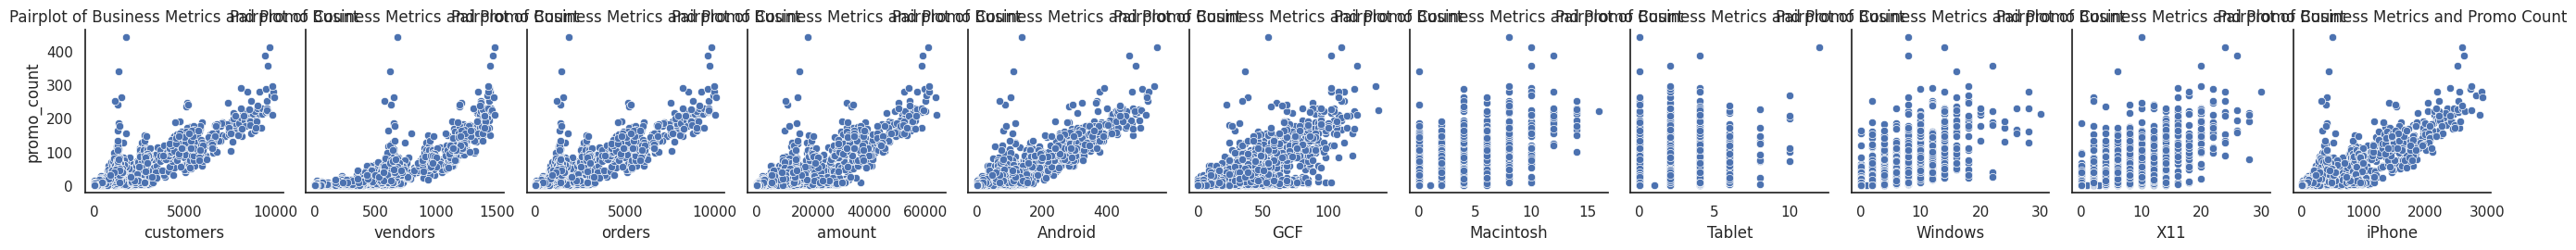

In [59]:
sns.pairplot(data=df, x_vars=['customers', 'vendors', 'orders', 'amount', 'Android', 'GCF', 'Macintosh', 'Tablet', 'Windows', 'X11', 'iPhone'], y_vars=['promo_count']).set(title='Pairplot of Business Metrics and Promo Count')

plt.show()

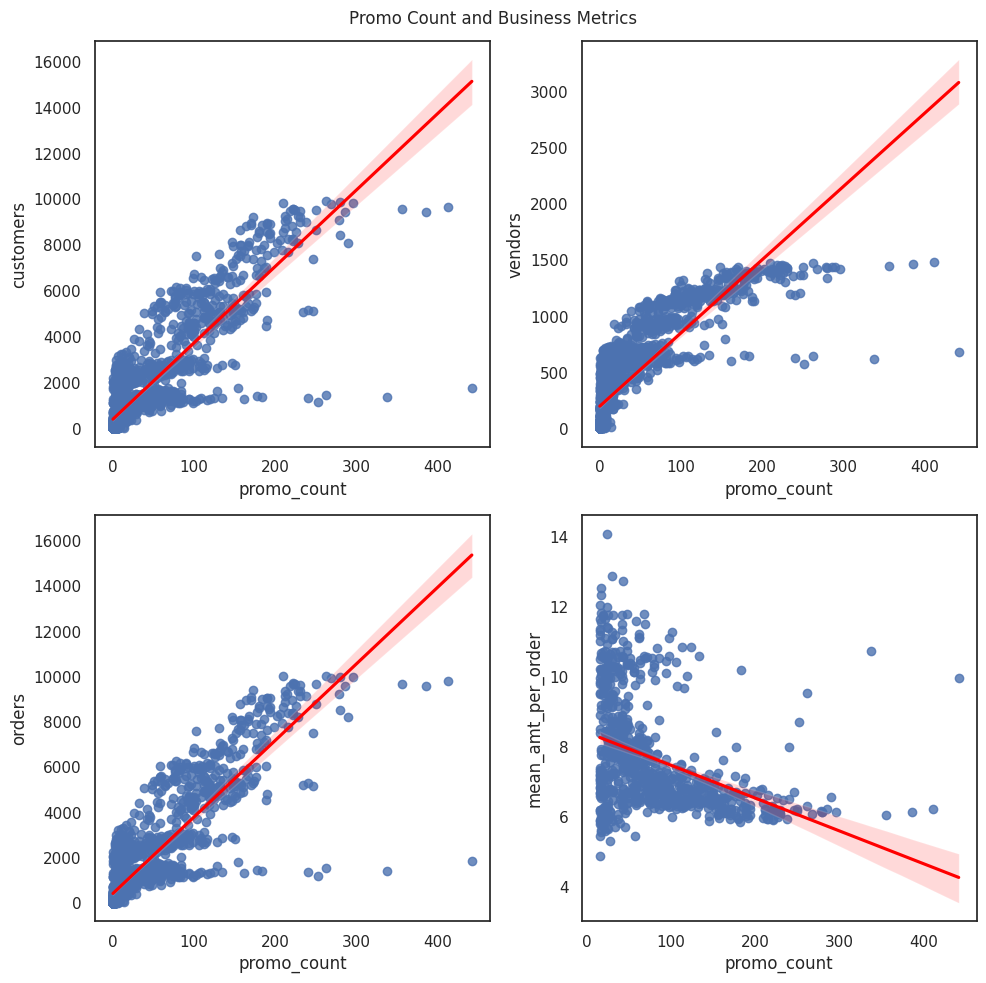

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

sns.regplot(data=df, x='promo_count', y='customers', fit_reg = True, line_kws={"color": "red"}, ax=ax1)
sns.regplot(data=df, x='promo_count', y='vendors', fit_reg = True, line_kws={"color": "red"}, ax=ax2)
sns.regplot(data=df, x='promo_count', y='orders', fit_reg = True, line_kws={"color": "red"}, ax=ax3)
sns.regplot(data=df[df.promo_count > 15], x='promo_count', y='mean_amt_per_order', fit_reg = True, line_kws={"color": "red"}, ax=ax4)

plt.suptitle('Promo Count and Business Metrics', size=12)
fig.tight_layout(pad=1)
plt.show()

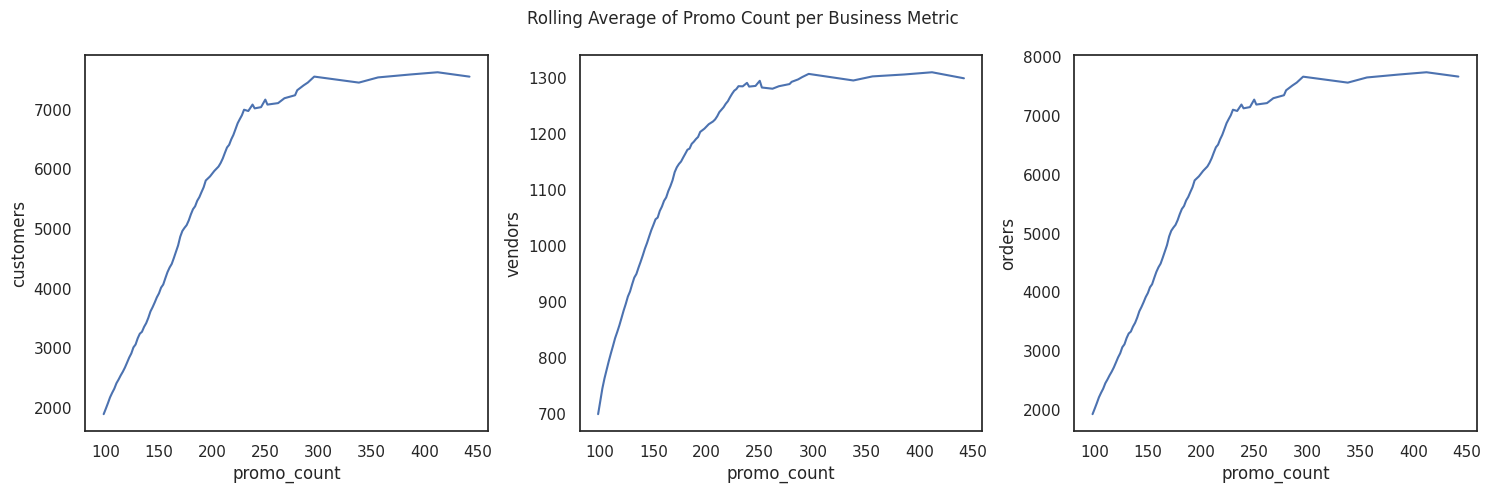

In [61]:
df_mean_promo = df.groupby('promo_count').median(numeric_only=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharex=True)

ax1.plot()
ax1.set_title = ('Customers')

sns.lineplot(x=df_mean_promo.index, y=df_mean_promo.customers.rolling(50).mean(), ax=ax1)

sns.lineplot(x=df_mean_promo.index, y=df_mean_promo.vendors.rolling(50).mean(), ax=ax2)

sns.lineplot(x=df_mean_promo.index, y=df_mean_promo.orders.rolling(50).mean(), ax=ax3)

plt.suptitle('Rolling Average of Promo Count per Business Metric', size=12)
fig.tight_layout(pad=1)
plt.show()



*   The regression line shows very strong positive correlation of promo_count towards customers, vendors, and orders.
*   As expected, the mean amount per order decreases as more promos are given to the customers.
*   Plotting the rolling averages shows point of diminishing return around 230 promo count.



## Device Usage

In [62]:
df_segment = pd.DataFrame([
    ['iPhone', df.iPhone.sum(), 'Mobile'], ['Android', df.Android.sum(), 'Mobile'], ['Tablet', df.Tablet.sum(), 'Mobile'],
    ['Mac', df.Macintosh.sum(), 'Non-mobile'], ['Windows', df.Windows.sum(), 'Non-mobile'], ['X11', df.X11.sum(), 'Non-mobile']],
    columns=['Device', 'Count', 'Bucket'])
df_segment_mobile_sum = df.mobile.sum()
df_segment_non_mobile_sum = df['non-mobile'].sum()

"""
fig, ax = plt.subplots(figsize=(10,10))
size = 0.4
ax.pie(df_segment['Count'], labels=df_segment['Device'],
       autopct='%1.2f%%', pctdistance=0.8,
       radius=1, wedgeprops=dict(width=size, edgecolor='w'))
ax.pie([df_segment_mobile_sum, df_segment_non_mobile_sum], labels=['Mobile', 'Non-mobile'], labeldistance=0.2,
       autopct='%1.2f%%', pctdistance=0.6,
       radius=1-size, wedgeprops=dict(width=size, edgecolor='w'))
plt.title('Orders by devices')
plt.show()
"""

"\nfig, ax = plt.subplots(figsize=(10,10))\nsize = 0.4\nax.pie(df_segment['Count'], labels=df_segment['Device'],\n       autopct='%1.2f%%', pctdistance=0.8,\n       radius=1, wedgeprops=dict(width=size, edgecolor='w'))\nax.pie([df_segment_mobile_sum, df_segment_non_mobile_sum], labels=['Mobile', 'Non-mobile'], labeldistance=0.2,\n       autopct='%1.2f%%', pctdistance=0.6,\n       radius=1-size, wedgeprops=dict(width=size, edgecolor='w'))\nplt.title('Orders by devices')\nplt.show()\n"

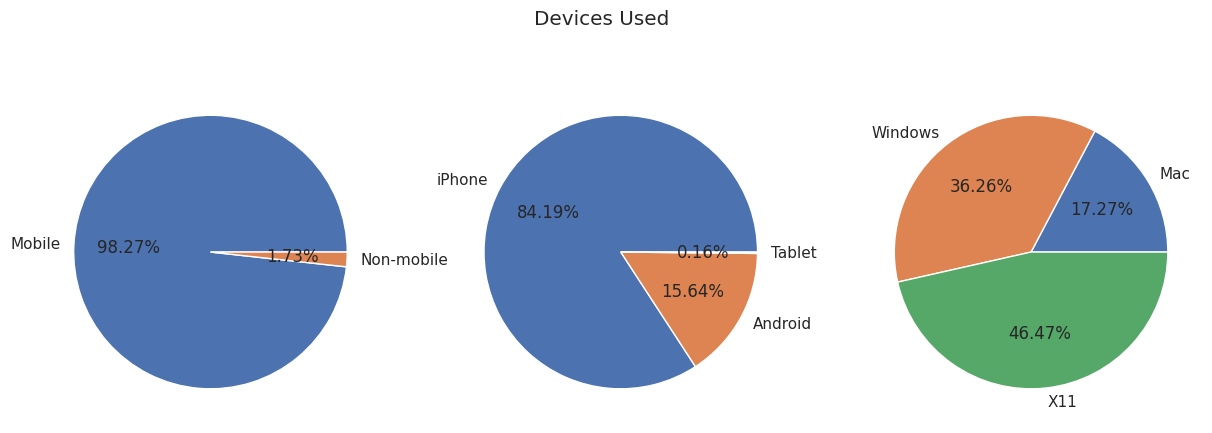

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.pie([df_segment_mobile_sum, df_segment_non_mobile_sum], labels=['Mobile', 'Non-mobile'], autopct='%1.2f%%')
ax2.pie(df_segment[df_segment.Bucket=='Mobile']['Count'], labels=df_segment[df_segment.Bucket=='Mobile']['Device'], autopct='%1.2f%%')
ax3.pie(df_segment[df_segment.Bucket=='Non-mobile']['Count'], labels=df_segment[df_segment.Bucket=='Non-mobile']['Device'], autopct='%1.2f%%')

plt.suptitle('Devices Used')
plt.show()



*   98.27% of recorded devices orders are placed using mobile devices of which 84.19% is iPhones.
*   On the contrary, Mac OS at 17.27% ranked lowest among non-mobile orders.




# Conclusion

*   The business is doing well in terms of quantity of order growth from January to May 2021 which is positively correltated with the promos given to the customers.
*   Covid has negligible correlation to orders as suggested by the coefficient.
*   ANOVA p-value indicates positive results from implementation of AI.
*   Majority of orders (98.3 %) are placed using mobile devices.
*   Morning has the highest activity while there are least during the evening.
*   There is significantly lower number of promos during the weekends.
*   Point of diminishing returns begin at 230 promos across different business metrics.


